<a href="https://colab.research.google.com/github/peisuke/GenPU/blob/main/toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn import datasets
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
X, z = datasets.make_moons(n_samples=2000, noise=0.05, random_state=0)

sc = preprocessing.StandardScaler()
sc.fit(X)
X = sc.transform(X) / 2

In [ ]:
s = z.copy()
s0 = np.zeros_like(s[s == 1])
s0[np.random.rand(len(s0)) > 0.8] = 1
s[s == 1] = s0

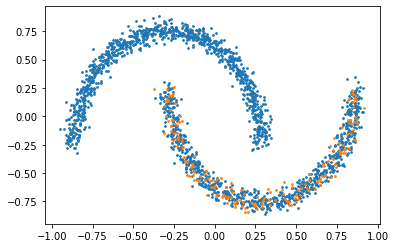

In [ ]:
plt.scatter(X[s==0,0], X[s==0,1], s=3)
plt.scatter(X[s==1,0], X[s==1,1], s=3)

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
batchsize = 50

labeled_dataset = Dataset(X[s == 1])
unlabeled_dataset = Dataset(X[s == 0])

labeled_loader = torch.utils.data.DataLoader(labeled_dataset, batch_size = batchsize, shuffle = True, num_workers = 2)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size = batchsize, shuffle = True, num_workers = 2)

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [ ]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
input_size = 64
gen_p = Generator(input_size=input_size).to(device)
gen_n = Generator(input_size=input_size).to(device)
dis_p = Discriminator().to(device)
dis_n = Discriminator().to(device)
dis_u = Discriminator().to(device)

dp_optimizer = torch.optim.Adam(dis_p.parameters(), lr = 1e-3)
dn_optimizer = torch.optim.Adam(dis_n.parameters(), lr = 1e-3)
du_optimizer = torch.optim.Adam(dis_u.parameters(), lr = 1e-3)
gp_optimizer = torch.optim.Adam(gen_p.parameters(), lr = 1e-3)
gn_optimizer = torch.optim.Adam(gen_n.parameters(), lr = 1e-3)

In [ ]:
def infiniteloop(dataloader):
    while True:
        for x in iter(dataloader):
            yield x

In [ ]:
real_label = 1.
fake_label = 0.
criterion = nn.BCELoss()

In [ ]:
labeled_looper = infiniteloop(labeled_loader)
num_epoch = 1000

loss_D_epoch = []
loss_G_epoch = []

for epoch in range(num_epoch):
    G_loss = 0
    D_loss = 0

    for i, unlabeled_x in enumerate(unlabeled_loader):
        z = torch.randn(batchsize, input_size, device=device)
        xp = next(labeled_looper).to(device)
        xu = unlabeled_x.to(device)

        if len(xp) != batchsize:
            continue
        if len(xu) != batchsize:
            continue

        dis_p.zero_grad()
        dis_n.zero_grad()
        dis_u.zero_grad()
        gen_p.zero_grad()
        gen_n.zero_grad()

        label = torch.full((batchsize,), real_label, dtype=torch.float32, device=device)

        # update discriminator (positive)
        label.fill_(real_label)
        out = dis_p(xp).view(-1)
        errDp_real = criterion(out, label)
        errDp_real.backward()
        Dp_x = out.mean().item()
        
        label.fill_(fake_label)
        fake_p = gen_p(z)
        out = dis_p(fake_p.detach()).view(-1)
        errDp_fake = criterion(out, label)
        errDp_fake.backward()
        Dp_Gp_z1 = out.mean().item()

        errDp = errDp_real + errDp_fake
        dp_optimizer.step()
        
        # update discriminator (negative)
        label.fill_(real_label)
        out = dis_n(xp).view(-1)
        errDn_real = criterion(out, label)
        errDn_real.backward()
        Dn_x = out.mean().item()

        label.fill_(fake_label)
        fake_n = gen_n(z)
        out = dis_n(fake_n.detach()).view(-1)
        errDn_fake = criterion(out, label)
        errDn_fake.backward()
        Dn_Gn_z1 = out.mean().item()

        errDn = errDn_real + errDn_fake
        dn_optimizer.step()

        # update discriminator (unlabeled)
        label.fill_(real_label)
        out = dis_u(xu).view(-1)
        errDu_real = criterion(out, label)
        errDu_real.backward()
        Du_x = out.mean().item()

        label.fill_(fake_label)
        out1 = dis_u(fake_p.detach()).view(-1)
        out2 = dis_u(fake_n.detach()).view(-1)
        errDu_fake = criterion(out1, label) + criterion(out2, label)
        errDu_fake.backward()
        du_optimizer.step()

        Du_Gp_z1 = out1.mean().item()
        Du_Gn_z1 = out2.mean().item()
        errDu = errDu_real + errDu_fake

        # update generator (positive)
        label.fill_(real_label)
        out1 = dis_p(fake_p).view(-1)
        out2 = dis_u(fake_p).view(-1)
        errGp_real= criterion(out1, label) + criterion(out2, label)
        errGp_real.backward()
        gp_optimizer.step()

        Dp_Gp_z2 = out1.mean().item()
        Du_Gp_z2 = out2.mean().item()
        
        # update generator (negative)
        label.fill_(real_label)
        label2 = torch.full((batchsize,), fake_label, dtype=torch.float32, device=device)
        out1 = dis_n(fake_n).view(-1)
        out2 = dis_u(fake_n).view(-1)
        errGn_real= criterion(out1, label2) + criterion(out2, label)
        errGn_real.backward()
        gn_optimizer.step()

        Dn_Gn_z2 = out1.mean().item()
        Du_Gn_z2 = out2.mean().item()
        
        total_errD = (errDp + errDn + errDu).item()
        total_errG = (errGp_real + errGn_real).item()
        G_loss += total_errG
        D_loss += total_errD
    G_loss /= len(unlabeled_loader)
    D_loss /= len(unlabeled_loader)

    loss_D_epoch.append(D_loss)
    loss_G_epoch.append(G_loss)
    if epoch % 10 == 0:
        print(f'[{epoch}/{num_epoch}]: LossD={D_loss}, LossG={G_loss}')

[0/1000]: LossD=3.388206739683409, LossG=2.275372724275331
[10/1000]: LossD=2.492092074574651, LossG=2.4048326079909867
[20/1000]: LossD=2.6108345276600606, LossG=2.103841446541451
[30/1000]: LossD=2.3222572545747497, LossG=2.196898067319715
[40/1000]: LossD=2.204339755548013, LossG=2.2987127948451684
[50/1000]: LossD=2.2660351637247445, LossG=2.2679632612176843
[60/1000]: LossD=2.284652039811418, LossG=2.1865467251958073
[70/1000]: LossD=2.41138590993108, LossG=2.2090606882765487
[80/1000]: LossD=2.3082787926132613, LossG=2.168390312710324
[90/1000]: LossD=2.15762811093717, LossG=2.4749279279966614
[100/1000]: LossD=2.2759577196997567, LossG=2.269512969094354
[110/1000]: LossD=2.348401701128161, LossG=2.1137513598880253
[120/1000]: LossD=2.424440255036225, LossG=2.1881272663941256
[130/1000]: LossD=2.335577765026608, LossG=2.3706368948962235
[140/1000]: LossD=2.3171250562410095, LossG=2.163456175778363
[150/1000]: LossD=2.348749173654092, LossG=2.249324573052896
[160/1000]: LossD=2.27

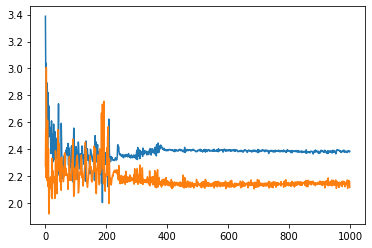

In [ ]:
plt.plot(loss_D_epoch)
plt.plot(loss_G_epoch)

In [ ]:
with torch.no_grad():
    z = torch.randn(256, input_size, device=device)
    out_p_fake = gen_p(z).cpu().numpy()
    out_n_fake = gen_n(z).cpu().numpy()
    xp = torch.tensor(labeled_dataset[0:256]).to(device)
    out_p_real = xp.cpu().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


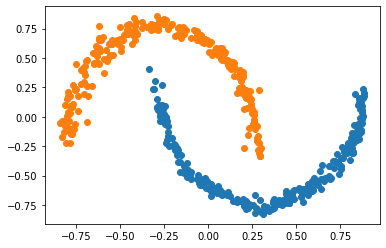

In [ ]:
plt.scatter(out_p_fake[:,0], out_p_fake[:,1])
plt.scatter(out_n_fake[:,0], out_n_fake[:,1])